In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import numpy as np

**Metals**
- GC: Gold
- SI: Silver

**Agriculture**
- ZS: Soybean
- ZC: Corn

**Softs**
- SC: Sugar
- CC: Cocoa

**Energy**
- CL: Crude Oil
- NG: Natural Gas

**Interest**
- ED: Eurodollar
- SR1: Short-Term Interest Rate

**Equity**
- ES: E-mini S&P 500
- NQ: E-mini Nasdaq-100

**Bonds**
- ZT: 2 years T-Note
- ZF: 5 years T-Note
- ZN: 10 years T-Note
- ZB: Treasury Bond Future
- UB: Ultra Treasury Bond Future

In [54]:
name = "es"

In [55]:
df = pd.read_csv(f"data/{name}.csv")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df.set_index("Date", inplace=True)
df = df[df.index.year >= 2000]


def get_name():
    return f"{name}: {df.index.min().year}-{df.index.max().year}"

In [56]:
code = "m"  # or U
# code = "U"  # or m


stp = 21 if code == "m" else 5
pow_fctr = 12 if code == "m" else 52

In [57]:
def get_annualized_return(series):
    # return series.pct_change().mean() * len(series) * 12 * 100
    # return series.pct_change().median() * 12 * 100


    start = series.iloc[0]
    end = series.iloc[-1]
    _rtr = (end - start) / start


    # return ((1 + _rtr) ** pow_fctr - 1) * 100

    return _rtr * 12 * 100

In [58]:
sample = df["Close"].resample("D").last().dropna()

Text(0.5, 1.0, 'es: 2000-2025 (Monthly Annualized Return)')

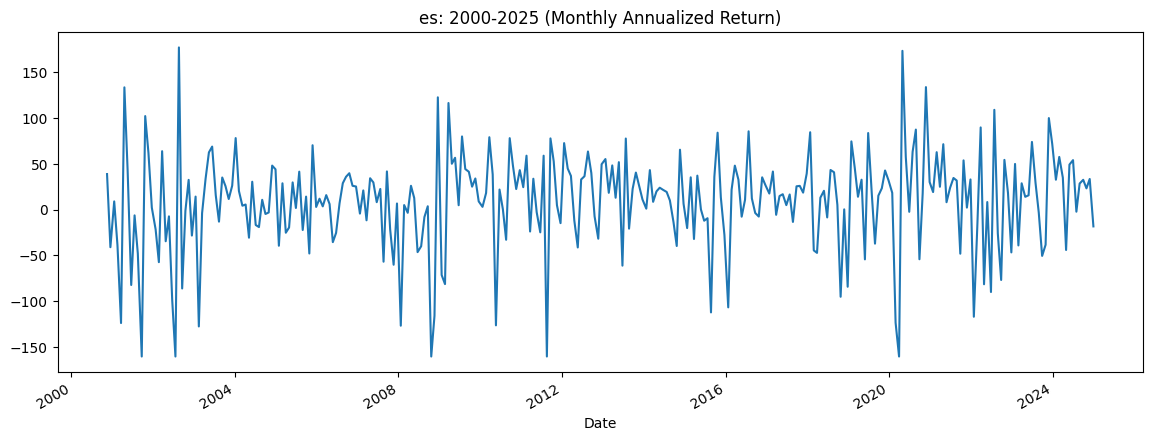

In [59]:
plt.figure(figsize=(14, 5))
annualized_rtr = sample.rolling(stp, step=stp).apply(get_annualized_return).dropna()[1:]

annualized_rtr = np.clip(
    annualized_rtr,
    annualized_rtr.mean() - 3 * annualized_rtr.std(),
    annualized_rtr.mean() + 3 * annualized_rtr.std(),
)

annualized_rtr.plot()
plt.title(f"{get_name()} (Monthly Annualized Return)")

In [60]:
def _get_df(name: str):
    df = pd.read_csv(f"data/{name}.csv")

    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    df.set_index("Date", inplace=True)
    df = df[df.index.year >= 2000]
    return df


def get_rtr_vol(names: list[str]):
    data_dict = {name: {"df": _get_df(name)} for name in names}

    for name in data_dict:
        _df = data_dict[name]["df"]
        data_dict[name]["sample"] = _df["Close"].resample("D").last().dropna()

        _rtr = data_dict[name]["sample"].pct_change().dropna() * 100
        _r_vol = _rtr.rolling(14).std().rolling(stp, step=stp).mean()
        data_dict[name]["vol"] = (_r_vol * np.sqrt(252)).dropna()
        
        
        _r_intv = data_dict[name]["sample"].rolling(stp, step=stp)
        data_dict[name]["rtr"] = _r_intv.apply(get_annualized_return).dropna()[1:]
        
    return data_dict

In [61]:
annualized_rtr.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    291.000000
mean       8.989067
std       53.456125
min     -160.504067
25%      -13.582314
50%       15.765070
75%       38.583368
90%       63.750859
95%       81.730968
99%      133.507632
max      177.092517
Name: Close, dtype: float64

Text(0.5, 1.0, 'es: 2000-2025 (Volatility)')

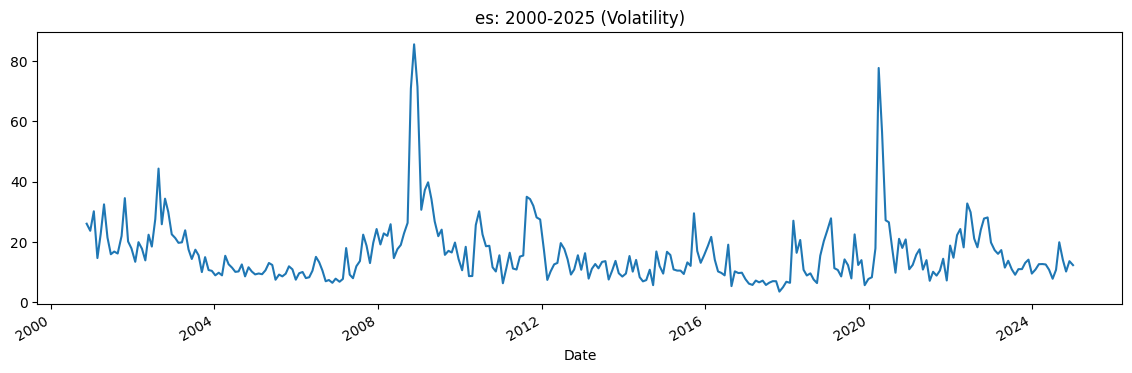

In [62]:
rtr = sample.pct_change().dropna() * 100
rolling_vol = (rtr.rolling(14).std().rolling(stp, step=stp).mean() * np.sqrt(252)).dropna()
plt.figure(figsize=(14, 4))
rolling_vol.plot()
plt.title(f"{get_name()} (Volatility)")

In [63]:
quintiles = rolling_vol.quantile([0.2, 0.4, 0.6, 0.8])
vol_q1 = rolling_vol[(0 <= rolling_vol) & (rolling_vol <= quintiles.values[0])]
vol_q2 = rolling_vol[(quintiles.values[0] < rolling_vol) & (rolling_vol <= quintiles.values[1])]
vol_q3 = rolling_vol[(quintiles.values[1] < rolling_vol) & (rolling_vol <= quintiles.values[2])]
vol_q4 = rolling_vol[(quintiles.values[2] < rolling_vol) & (rolling_vol <= quintiles.values[3])]
vol_q5 = rolling_vol[quintiles.values[3] < rolling_vol]

In [64]:
print(quintiles)

0.2     9.199463
0.4    11.413507
0.6    15.537323
0.8    21.281878
Name: Close, dtype: float64


In [65]:
nq1_lookup = [f"{i.year}_{int(dt.strftime(i, f'%{code}'))+1:>02}" for i in vol_q1.index]
nq2_lookup = [f"{i.year}_{int(dt.strftime(i, f'%{code}'))+1:>02}" for i in vol_q2.index]
nq3_lookup = [f"{i.year}_{int(dt.strftime(i, f'%{code}'))+1:>02}" for i in vol_q3.index]
nq4_lookup = [f"{i.year}_{int(dt.strftime(i, f'%{code}'))+1:>02}" for i in vol_q4.index]
nq5_lookup = [f"{i.year}_{int(dt.strftime(i, f'%{code}'))+1:>02}" for i in vol_q5.index]


nq1_lookup = [
    (
        f"{int(i[:4])+1}_01"
        if (i.endswith("13") and code == "m") or i.endswith("53")
        else i
    )
    for i in nq1_lookup
]
nq2_lookup = [
    (
        f"{int(i[:4])+1}_01"
        if (i.endswith("13") and code == "m") or i.endswith("53")
        else i
    )
    for i in nq2_lookup
]
nq3_lookup = [
    (
        f"{int(i[:4])+1}_01"
        if (i.endswith("13") and code == "m") or i.endswith("53")
        else i
    )
    for i in nq3_lookup
]
nq4_lookup = [
    (
        f"{int(i[:4])+1}_01"
        if (i.endswith("13") and code == "m") or i.endswith("53")
        else i
    )
    for i in nq4_lookup
]
nq5_lookup = [
    (
        f"{int(i[:4])+1}_01"
        if (i.endswith("13") and code == "m") or i.endswith("53")
        else i
    )
    for i in nq5_lookup
]

In [66]:
n_vol_q1 = rolling_vol[rolling_vol.index.strftime(f"%Y_%{code}").isin(nq1_lookup)]
n_vol_q2 = rolling_vol[rolling_vol.index.strftime(f"%Y_%{code}").isin(nq2_lookup)]
n_vol_q3 = rolling_vol[rolling_vol.index.strftime(f"%Y_%{code}").isin(nq3_lookup)]
n_vol_q4 = rolling_vol[rolling_vol.index.strftime(f"%Y_%{code}").isin(nq4_lookup)]
n_vol_q5 = rolling_vol[rolling_vol.index.strftime(f"%Y_%{code}").isin(nq5_lookup)]

In [67]:
n_rtr_q1 = annualized_rtr[annualized_rtr.index.strftime(f"%Y_%{code}").isin(nq1_lookup)]
n_rtr_q2 = annualized_rtr[annualized_rtr.index.strftime(f"%Y_%{code}").isin(nq2_lookup)]
n_rtr_q3 = annualized_rtr[annualized_rtr.index.strftime(f"%Y_%{code}").isin(nq3_lookup)]
n_rtr_q4 = annualized_rtr[annualized_rtr.index.strftime(f"%Y_%{code}").isin(nq4_lookup)]
n_rtr_q5 = annualized_rtr[annualized_rtr.index.strftime(f"%Y_%{code}").isin(nq5_lookup)]

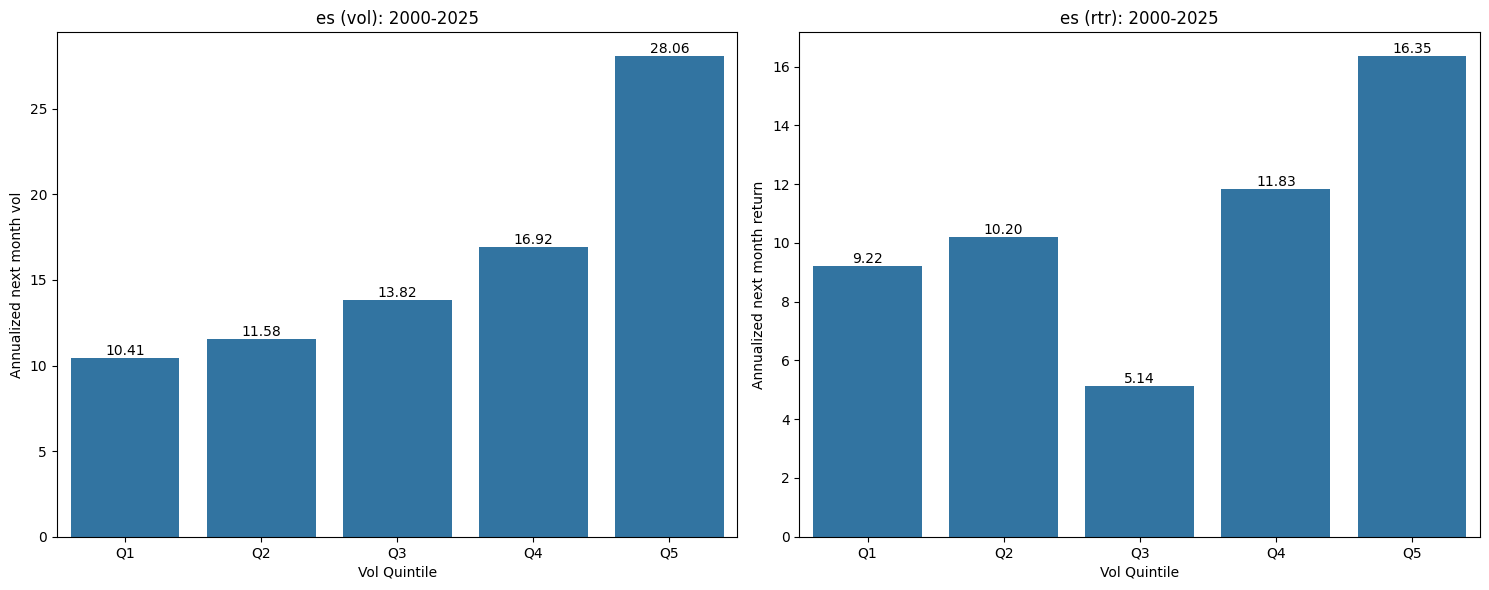

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

labels = ["Q1", "Q2", "Q3", "Q4", "Q5"]

values_rtr = [
    n_rtr_q1.mean(),
    n_rtr_q2.mean(),
    n_rtr_q3.mean(),
    n_rtr_q4.mean(),
    n_rtr_q5.mean(),
]

sns.barplot(x=labels, y=values_rtr, ax=ax2)

for i, value in enumerate(values_rtr):
    ax2.text(i, value, f"{value:.2f}", ha="center", va="bottom")

ax2.set_ylabel(f"Annualized next {'week' if code=='U' else 'month'} return")
ax2.set_xlabel("Vol Quintile")
ax2.set_title(f"{name} (rtr): {df.index.min().year}-{df.index.max().year}")


# First subplot (Volatility)
values_vol = [
    n_vol_q1.mean(),
    n_vol_q2.mean(),
    n_vol_q3.mean(),
    n_vol_q4.mean(),
    n_vol_q5.mean(),
]

sns.barplot(x=labels, y=values_vol, ax=ax1)

for i, value in enumerate(values_vol):
    ax1.text(i, value, f"{value:.2f}", ha="center", va="bottom")

ax1.set_ylabel(f"Annualized next {'week' if code=='U' else 'month'} vol")
ax1.set_xlabel("Vol Quintile")
ax1.set_title(f"{name} (vol): {df.index.min().year}-{df.index.max().year}")

# Second subplot (Returns)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'es: 2000-2025 (vol distribution)')

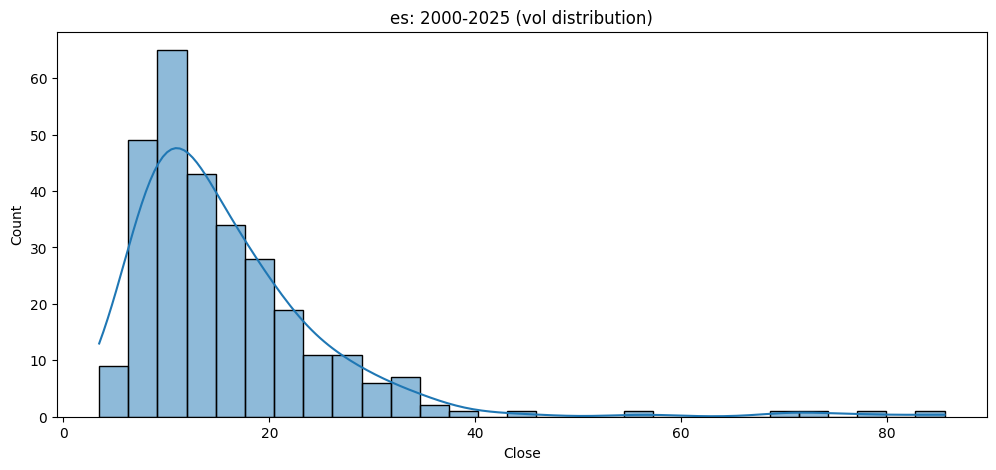

In [69]:
plt.figure(figsize=(12,5))
sns.histplot(rolling_vol, kde=True)
plt.title(f"{get_name()} (vol distribution)")

In [70]:
print(" Volatility Stats ")
print("Mean".ljust(10), rolling_vol.mean())
print("Median".ljust(10), rolling_vol.median())
print("Std Dev".ljust(10), rolling_vol.std())
print("Skew ".ljust(10), rolling_vol.skew())
print("Kurt".ljust(10), rolling_vol.kurt())

 Volatility Stats 
Mean       16.093799059403455
Median     13.377639540184951
Std Dev    10.480500471640982
Skew       3.166255363035257
Kurt       14.986942266345398


Text(0.5, 1.0, 'es: 2000-2025 (return dist)')

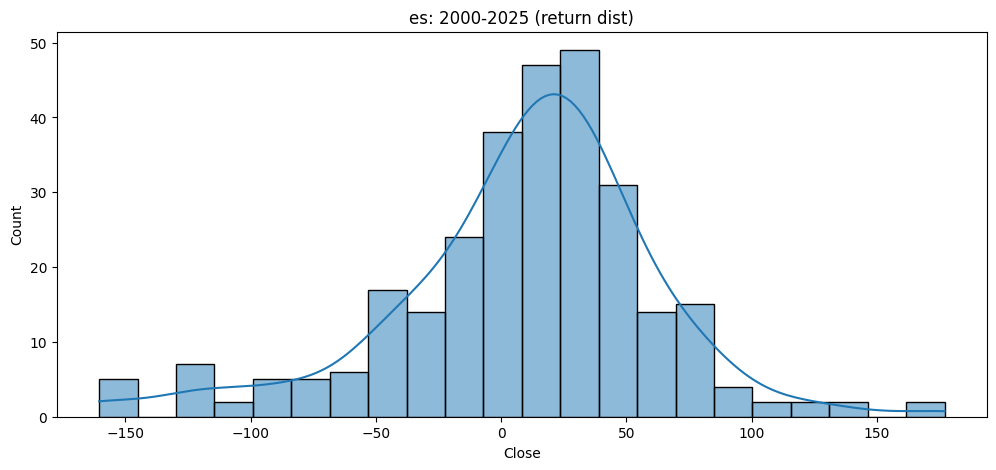

In [71]:
plt.figure(figsize=(12,5))
sns.histplot(annualized_rtr, kde=True)
plt.title(f"{get_name()} (return dist)")

In [72]:
print("Monthly Returns (Annualized) Stats\n")
print("Mean".ljust(10), annualized_rtr.mean())
print("Median".ljust(10), annualized_rtr.median())
print("Std Dev".ljust(10), annualized_rtr.std())
print("Skew ".ljust(10), annualized_rtr.skew())
print("Kurt".ljust(10), annualized_rtr.kurt())

Monthly Returns (Annualized) Stats

Mean       8.98906677571707
Median     15.765069551777437
Std Dev    53.456125269350764
Skew       -0.6588622074866137
Kurt       1.689778625130276


In [73]:
# rolling_vol = rolling_vol[1:]

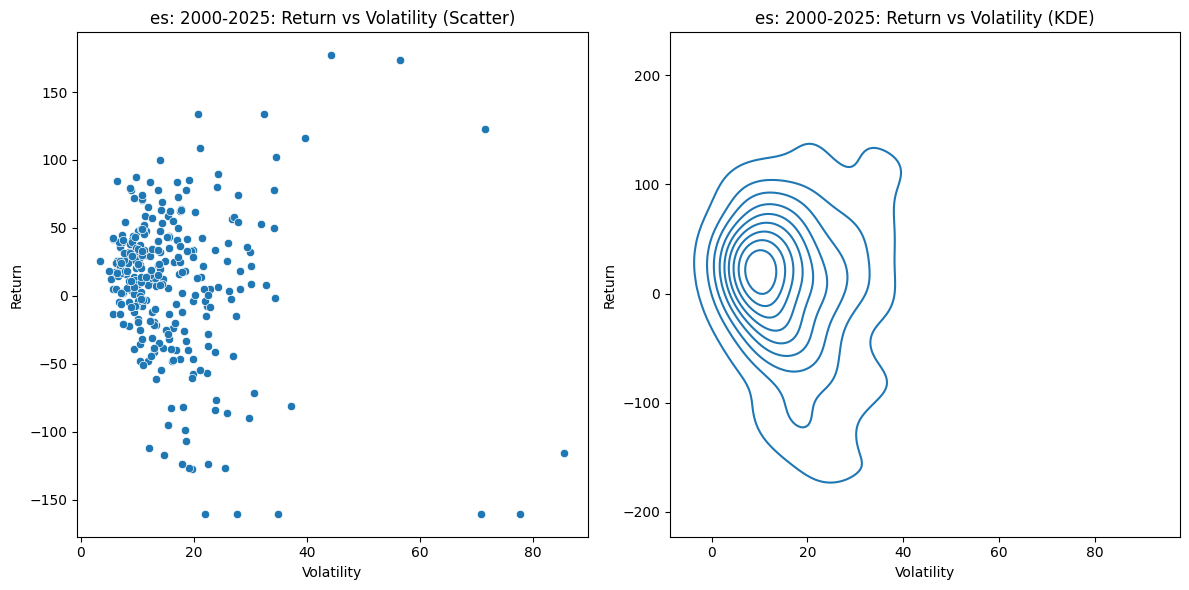

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(y=annualized_rtr.values, x=rolling_vol.values, ax=ax1)
ax1.set_xlabel("Volatility")
ax1.set_ylabel("Return")
ax1.set_title(f"{get_name()}: Return vs Volatility (Scatter)")

sns.kdeplot(y=annualized_rtr.values, x=rolling_vol.values, ax=ax2)
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Return")
ax2.set_title(f"{get_name()}: Return vs Volatility (KDE)")

plt.tight_layout()
plt.show()

## Correlation between $Return_t$ & $Vol_t^2 (Var_t)$

In [75]:
np.corrcoef(annualized_rtr.values, rolling_vol.values**2)[0][1]

np.float64(-0.15046393723812465)

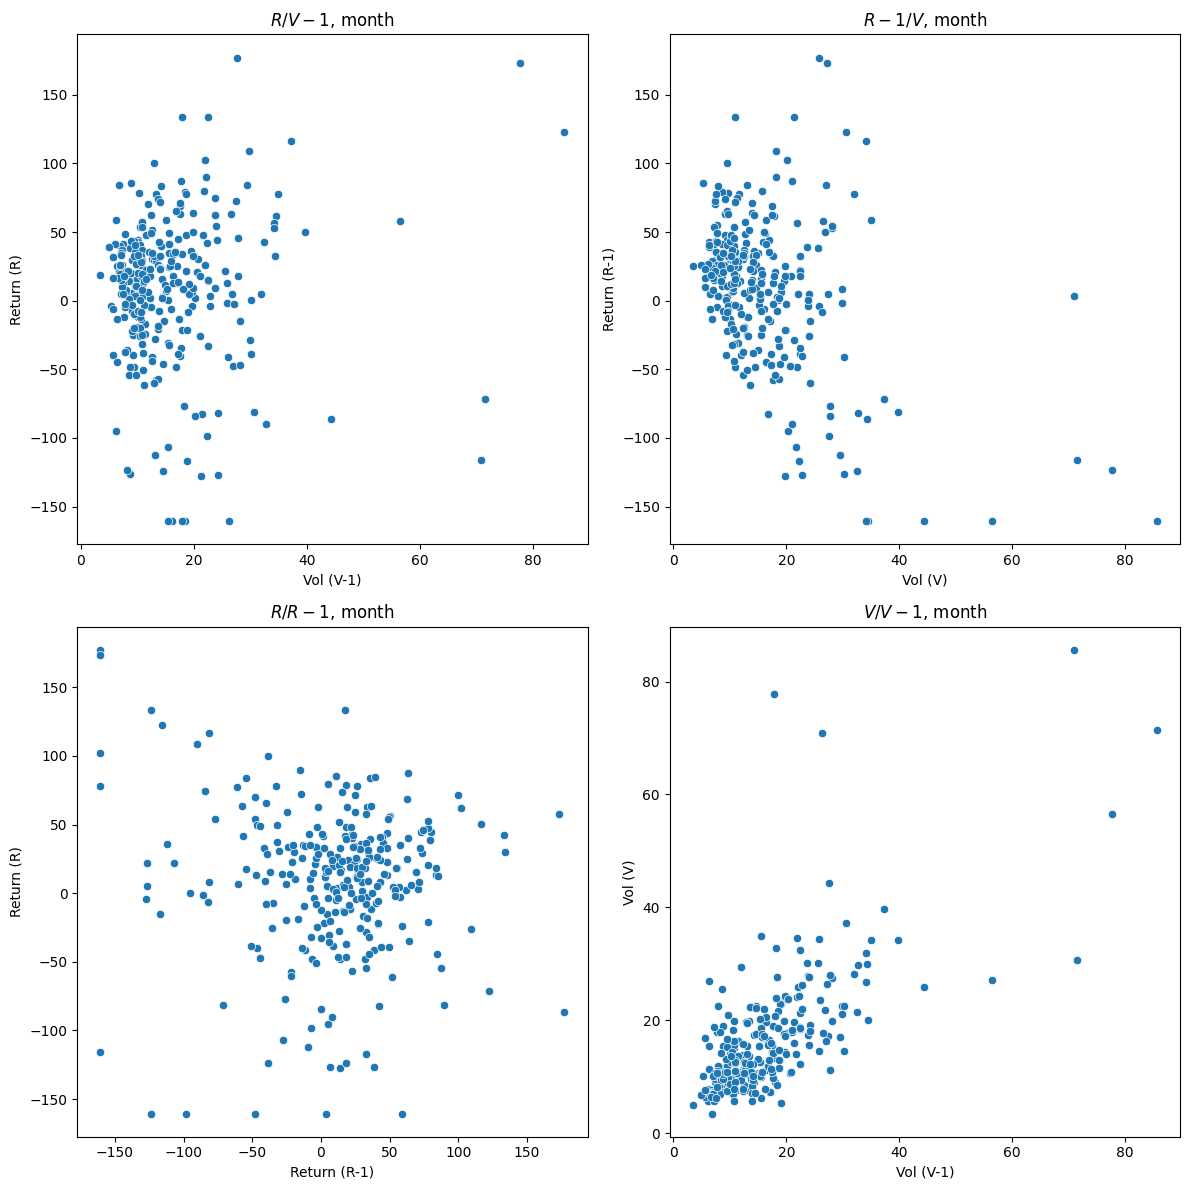

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: R/V-1
sns.scatterplot(y=annualized_rtr[1:].values, x=rolling_vol[:-1].values, ax=ax1)
ax1.set_ylabel("Return (R)")
ax1.set_xlabel("Vol (V-1)")
ax1.set_title("$R/V-1$, " + ("week" if code == "U" else "month"))

# Plot 2: R-1/V
sns.scatterplot(y=annualized_rtr[:-1].values, x=rolling_vol[1:].values, ax=ax2)
ax2.set_ylabel("Return (R-1)")
ax2.set_xlabel("Vol (V)")
ax2.set_title("$R-1/V$, " + ("week" if code == "U" else "month"))

# Plot 3: R/R-1
sns.scatterplot(y=annualized_rtr[1:].values, x=annualized_rtr[:-1].values, ax=ax3)
ax3.set_ylabel("Return (R)")
ax3.set_xlabel("Return (R-1)")
ax3.set_title("$R/R-1$, " + ("week" if code == "U" else "month"))

# Plot 4: V/V-1
sns.scatterplot(y=rolling_vol[1:].values, x=rolling_vol[:-1].values, ax=ax4)
ax4.set_ylabel("Vol (V)")
ax4.set_xlabel("Vol (V-1)")
ax4.set_title("$V/V-1$, " + ("week" if code == "U" else "month"))

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

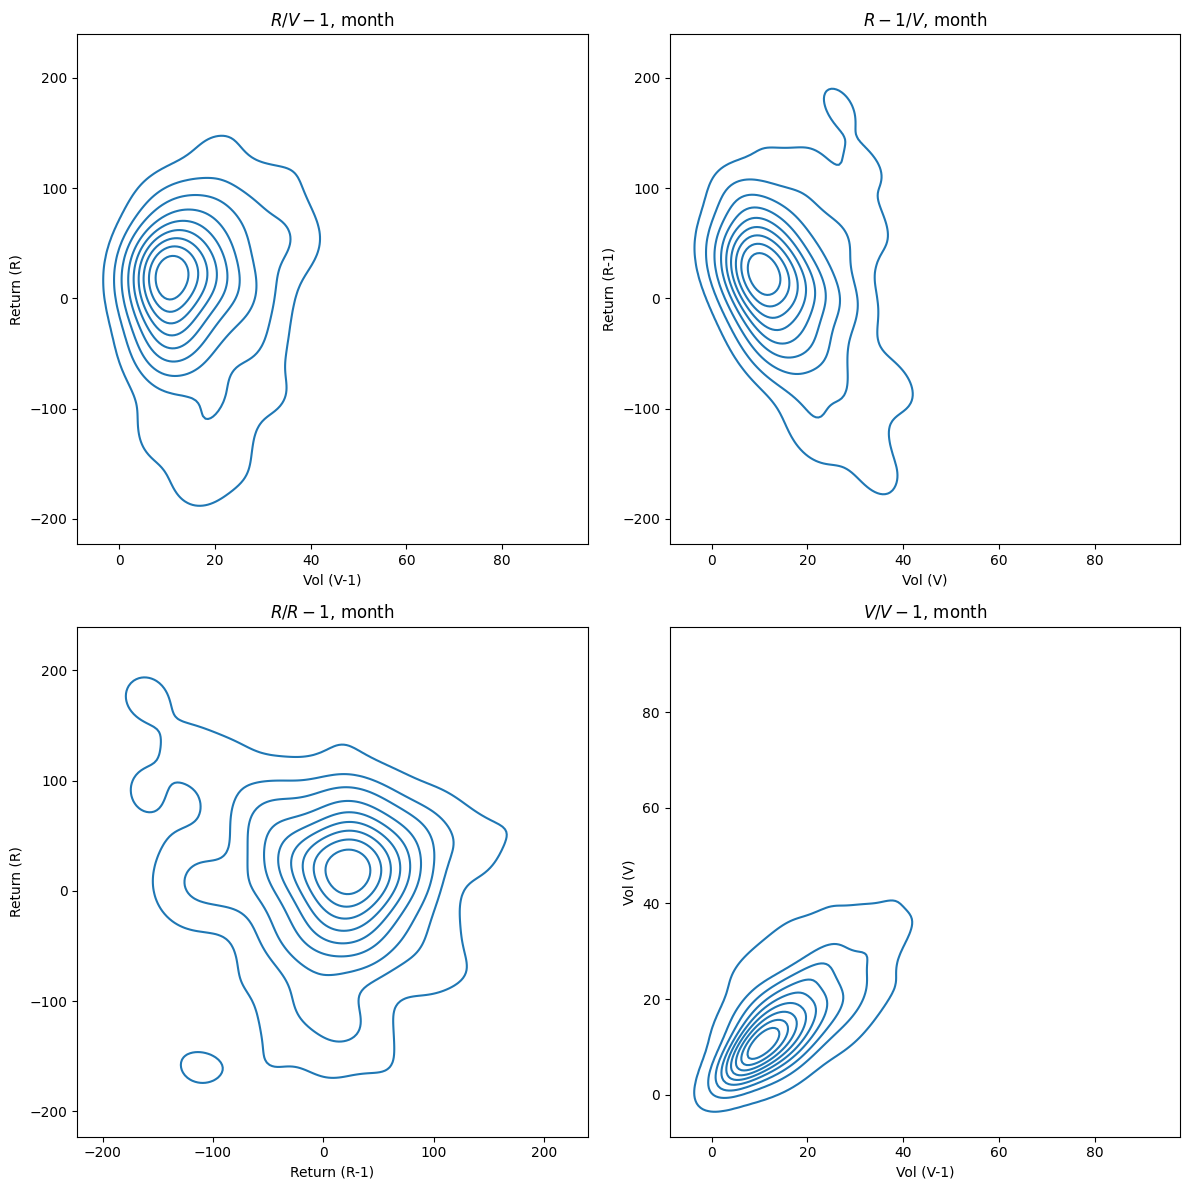

In [77]:
# Create a figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

# Plot 1: R/V-1
sns.kdeplot(y=annualized_rtr[1:].values, x=rolling_vol[:-1].values, ax=ax1)
ax1.set_ylabel("Return (R)")
ax1.set_xlabel("Vol (V-1)")
ax1.set_title("$R/V-1$, " + ("week" if code == "U" else "month"))

# Plot 2: R-1/V
sns.kdeplot(y=annualized_rtr[:-1].values, x=rolling_vol[1:].values, ax=ax2)
ax2.set_ylabel("Return (R-1)")
ax2.set_xlabel("Vol (V)")
ax2.set_title("$R-1/V$, " + ("week" if code == "U" else "month"))

# Plot 3: R/R-1
sns.kdeplot(y=annualized_rtr[1:].values, x=annualized_rtr[:-1].values, ax=ax3)
ax3.set_ylabel("Return (R)")
ax3.set_xlabel("Return (R-1)")
ax3.set_title("$R/R-1$, " + ("week" if code == "U" else "month"))

# Plot 4: V/V-1
sns.kdeplot(y=rolling_vol[1:].values, x=rolling_vol[:-1].values, ax=ax4)
ax4.set_ylabel("Vol (V)")
ax4.set_xlabel("Vol (V-1)")
ax4.set_title("$V/V-1$, " + ("week" if code == "U" else "month"))

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


---
## Analysis Ends
---

In [78]:
1 / 0

ZeroDivisionError: division by zero

In [ ]:
import yfinance as yf
fname = "cc"
dat = yf.Ticker(f"{fname}=F".capitalize())
_yf = dat.history(period="max")
newdf = _yf['Close']
newdf

In [ ]:
newdf.index =  newdf.index.date
newdf

In [1804]:
newdf = newdf.reset_index()
newdf.columns = ['Date', 'Close']
newdf.to_csv(f"data/{fname}.csv", index=False)